In [1]:
# Trabajo Práctico N°4 - Big Data & Machine Learning
# Universidad de Buenos Aires, 2025
# Grupo: 1
# Región seleccionada: Gran Buenos Aires
# ----------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los archivos de datos
try:
    df_2004 = pd.read_stata('usu_individual_T104.dta')
    df_2024 = pd.read_excel('usu_individual_T124.xlsx')
except FileNotFoundError as e:
    print(f"Error al cargar archivos: {e}")
    raise

# Estandarizar nombres de columnas a mayúsculas
df_2004.columns = df_2004.columns.str.upper()
df_2024.columns = df_2024.columns.str.upper()

# Homogeneizar CH04: convertir a 'Hombre' / 'Mujer'
df_2004['CH04'] = df_2004['CH04'].replace({'Hombre': 'Hombre', 'Mujer': 'Mujer'})
df_2024['CH04'] = df_2024['CH04'].replace({1: 'Hombre', 2: 'Mujer'})

# Filtrar solo Gran Buenos Aires
df_2004['REGION'] = df_2004['REGION'].astype(str)
df_2024['REGION'] = df_2024['REGION'].astype(str)
df_2004 = df_2004[df_2004['REGION'] == 'Gran Buenos Aires']
df_2024 = df_2024[df_2024['REGION'] == '1']

# Agregar columna de año
df_2004['ANO4'] = 2004
df_2024['ANO4'] = 2024

# Seleccionar variables comunes
variables_comunes = [
    'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 
    'CAT_INAC', 'IPCF', 'P21', 'PP04D_COD', 'P47T', 'CH12', 'CH13', 'CH14',
    'REGION', 'AGLOMERADO', 'TRIMESTRE', 'ANO4'
]

# Convertir variables numéricas
numeric_vars = ['CH06', 'IPCF', 'P21', 'P47T']
for var in numeric_vars:
    if var in df_2004.columns:
        df_2004[var] = pd.to_numeric(df_2004[var], errors='coerce')
    if var in df_2024.columns:
        df_2024[var] = pd.to_numeric(df_2024[var], errors='coerce')

# Unir dataframes
df_combinado = pd.concat(
    [df_2004[variables_comunes], df_2024[variables_comunes]],
    ignore_index=True
)

# Verificar observaciones por año
print("Conteo de observaciones por año:")
print(df_combinado['ANO4'].value_counts())

# Análisis de valores faltantes
valores_faltantes = df_combinado[variables_comunes].isna().sum()
print("Valores faltantes por variable:")
print(valores_faltantes)

faltantes_por_anio = df_combinado.groupby("ANO4").apply(lambda df: df.isnull().sum())
faltantes_por_anio = faltantes_por_anio.transpose()
print("Valores faltantes por año:")
print(faltantes_por_anio)

# Comentario: La variable PP04D_COD tiene 3827 valores faltantes en 2024, probablemente porque no todas las personas respondieron sobre su ocupación específica. CH06 (edad) tiene 135 faltantes en 2004, lo que puede deberse a errores en la recolección de datos. P47T (ingreso total) tiene 41 faltantes en 2024, lo que refleja no respuestas.

# Limpieza de ingresos negativos
df_combinado['P47T'] = df_combinado['P47T'].apply(lambda x: x if x is None or x >= 0 else np.nan)
df_combinado['IPCF'] = df_combinado['IPCF'].apply(lambda x: x if x is None or x >= 0 else np.nan)

print("Cantidad de valores NaN en ingresos después de limpiar:")
print("P47T:", df_combinado['P47T'].isna().sum())
print("IPCF:", df_combinado['IPCF'].isna().sum())



Conteo de observaciones por año:
ANO4
2004    7647
2024    7051
Name: count, dtype: int64
Valores faltantes por variable:
CH04             0
CH06           135
CH07             0
CH08             0
NIVEL_ED         0
ESTADO           0
CAT_INAC         0
IPCF             0
P21              0
PP04D_COD     3827
P47T            41
CH12             0
CH13             0
CH14          3686
REGION           0
AGLOMERADO       0
TRIMESTRE        0
ANO4             0
dtype: int64
Valores faltantes por año:
ANO4        2004  2024
CH04           0     0
CH06         135     0
CH07           0     0
CH08           0     0
NIVEL_ED       0     0
ESTADO         0     0
CAT_INAC       0     0
IPCF           0     0
P21            0     0
PP04D_COD      0  3827
P47T           0    41
CH12           0     0
CH13           0     0
CH14           0  3686
REGION         0     0
AGLOMERADO     0     0
TRIMESTRE      0     0
ANO4           0     0
Cantidad de valores NaN en ingresos después de limpiar:
P47

In [17]:

# Normalizar ESTADO
estado_map = {
    1: "Ocupado", 2: "Desocupado", 3: "Inactivo", 4: "Menor de 10 años", 0: "No respondió",
    "Ocupado": "Ocupado", "Desocupado": "Desocupado", "Inactivo": "Inactivo",
    "Menor de 10 años": "Menor de 10 años",
    "Entrevista individual no realizada (no respuesta al cuestionario individual)": "No respondió"
}
df_combinado["ESTADO"] = df_combinado["ESTADO"].replace(estado_map)

# Conteo por ESTADO y AÑO
conteo_estado_anio = df_combinado.groupby(["ANO4", "ESTADO"]).size().unstack(fill_value=0)
print("Conteo por ESTADO y AÑO:")
print(conteo_estado_anio)

Conteo por ESTADO y AÑO:
ESTADO  Desocupado  \
ANO4                 
2004           528   
2024           311   

ESTADO  Entrevista individual no realizada (no respuesta al cuestion  \
ANO4                                                                   
2004                                                   10              
2024                                                    0              

ESTADO  Inactivo  Menor de 10 años  No respondió  Ocupado  
ANO4                                                       
2004        2800              1230             0     3079  
2024        2662               813            41     3224  


In [18]:
# Media IPCF por ESTADO y AÑO
media_ipcf_estado_anio = df_combinado.groupby(["ANO4", "ESTADO"])["IPCF"].mean().unstack()
print("\nMedia de IPCF por ESTADO y AÑO:")
print(media_ipcf_estado_anio)

# Comentario: Entre 2004 y 2024, el número de desocupados disminuyó de 528 a 311, lo que podría reflejar una mejora en el mercado laboral o un aumento de la inactividad. Los ingresos per cápita (IPCF) de los ocupados aumentaron significativamente en 2024 (207,644 vs. 476 en 2004), probablemente debido a la inflación. Los desocupados tienen ingresos mucho menores, especialmente en 2004 (224 vs. 85,019 en 2024).


Media de IPCF por ESTADO y AÑO:
ESTADO    Desocupado  \
ANO4                   
2004      224.231970   
2024    85019.145466   

ESTADO  Entrevista individual no realizada (no respuesta al cuestion  \
ANO4                                                                   
2004                                            52.533333              
2024                                                  NaN              

ESTADO       Inactivo  Menor de 10 años  No respondió        Ocupado  
ANO4                                                                  
2004       315.891856        246.259032           NaN     476.064755  
2024    130704.601499     104353.663296           0.0  207644.844045  


In [19]:
# Personas que no respondieron
no_respondieron_count = df_combinado[df_combinado["ESTADO"] == "No respondió"].shape[0]
print(f"Cantidad de personas que no respondieron su condición de actividad: {no_respondieron_count}")

respondieron = df_combinado[df_combinado["ESTADO"] != "No respondió"].copy()
norespondieron = df_combinado[df_combinado["ESTADO"] == "No respondió"].copy()
respondieron.to_csv("respondieron.csv", index=False)
# -------------------------------
# Enriquecer respondieron con variables necesarias
# -------------------------------

# Recalcular edad2
respondieron['edad2'] = respondieron['CH06'] ** 2

# Calcular educación
def calcular_educ(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    try:
        ultimo = int(row['CH14'])
    except:
        ultimo = np.nan
    if ultimo > 10 or ultimo < 0:
        ultimo = np.nan
    if finalizo == 1:
        return {
            1: 0, 2: 7, 3: 9, 4: 12, 5: 12, 6: 14, 7: 17, 8: 19
        }.get(nivel, np.nan)
    else:
        base = {
            1: 0, 2: 0, 3: 0, 4: 7, 5: 7, 6: 12, 7: 14, 8: 17
        }.get(nivel, 0)
        return base + ultimo if not np.isnan(ultimo) else np.nan

respondieron['educ'] = respondieron.apply(calcular_educ, axis=1)

# Ajustar ingresos por IPC
respondieron['P21_ajustado'] = np.where(respondieron['ANO4'] == 2004,
                                        respondieron['P21'] * 2985,
                                        respondieron['P21'])

# Salario semanal (0 si desocupado)
respondieron['salario_semanal'] = np.where(
    respondieron['ESTADO'] == 'Ocupado',
    respondieron['P21_ajustado'] / 40,
    0
)

# Horas trabajadas (reextraer desde df_2004/df_2024 originales)
df_2004_horas = df_2004[['PP3E_TOT', 'PP3F_TOT']].reset_index(drop=True)
df_2024_horas = df_2024[['PP3E_TOT', 'PP3F_TOT']].reset_index(drop=True)
df_horas = pd.concat([df_2004_horas, df_2024_horas], ignore_index=True)

# Reajustar índices
df_combinado = df_combinado.reset_index(drop=True)
df_combinado[['PP3E_TOT', 'PP3F_TOT']] = df_horas

# Volver a asignar horas al respondieron
respondieron = respondieron.reset_index(drop=True)
respondieron[['PP3E_TOT', 'PP3F_TOT']] = df_horas.loc[respondieron.index]
respondieron['horastrab'] = respondieron['PP3E_TOT'].fillna(0) + respondieron['PP3F_TOT'].fillna(0)

# Guardar CSV enriquecido
respondieron.to_csv("respondieron_enriquecido.csv", index=False)

norespondieron.to_csv("norespondieron.csv", index=False)

Cantidad de personas que no respondieron su condición de actividad: 41


In [20]:
# Desocupados
df_combinado["desocupado"] = df_combinado["ESTADO"].apply(lambda x: 1 if x == "Desocupado" else 0)
desocupados_por_anio = df_combinado.groupby("ANO4")["desocupado"].sum()
print("Cantidad de personas desocupadas por año:")
print(desocupados_por_anio)

Cantidad de personas desocupadas por año:
ANO4
2004    528
2024    311
Name: desocupado, dtype: int64


In [21]:
def calcular_educ(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    try:
        ultimo = int(row['CH14'])
    except:
        ultimo = np.nan

    # valores irreales: años mayores a 10 o marcadores especiales (98, 99)
    if ultimo > 10 or ultimo < 0:
        ultimo = np.nan

    if finalizo == 1:
        return {
            1: 0,
            2: 7,
            3: 9,
            4: 12,
            5: 12,
            6: 14,
            7: 17,
            8: 19
        }.get(nivel, np.nan)
    else:
        base = {
            1: 0,
            2: 0,
            3: 0,
            4: 7,
            5: 7,
            6: 12,
            7: 14,
            8: 17
        }.get(nivel, 0)
        return base + ultimo if not np.isnan(ultimo) else np.nan

# Aplicar la función nuevamente
df_combinado['educ'] = df_combinado.apply(calcular_educ, axis=1)



In [22]:
# Recalcular descripción
stats = df_combinado['educ'].describe(percentiles=[0.5])

# Redondear y renombrar
stats_round = stats.round(2)
stats_round.rename(index={
    'count': 'Cantidad',
    'mean': 'Media',
    'std': 'Desvío estándar',
    'min': 'Mínimo',
    '50%': 'Mediana',
    'max': 'Máximo'
}, inplace=True)

# Mostrar
print(stats_round)


Cantidad           10418.00
Media                  7.75
Desvío estándar        5.47
Mínimo                 0.00
Mediana                7.00
Máximo                23.00
Name: educ, dtype: float64


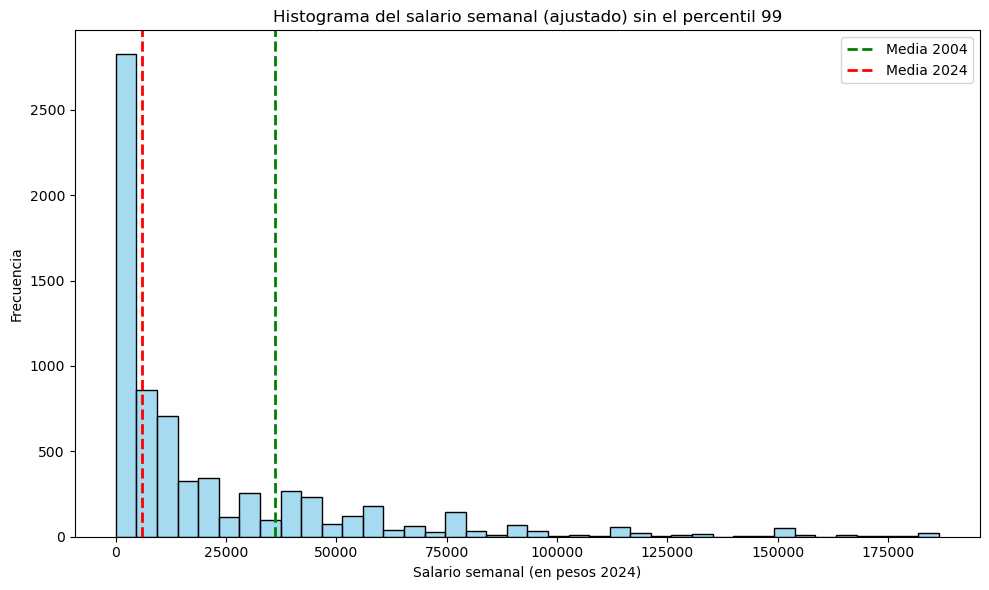

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear columna P21 ajustado al IPC
df_combinado['P21_ajustado'] = np.where(df_combinado['ANO4'] == 2004,
                                        df_combinado['P21'] * 2985,
                                        df_combinado['P21'])

# 2. Calcular salario_semanal (0 si desocupado)
df_combinado['salario_semanal'] = np.where(
    df_combinado['ESTADO'] == 'Ocupado',
    df_combinado['P21_ajustado'] / 40,
    0
)

# 3. Filtrar ocupados y desocupados con salario_semanal válido
df_filtrado = df_combinado[
    (df_combinado['ESTADO'].isin(['Ocupado', 'Desocupado'])) &
    (df_combinado['salario_semanal'].notna())
].copy()

# 4. Calcular el percentil 99
p99 = df_filtrado['salario_semanal'].quantile(0.99)

# 5. Eliminar observaciones mayores al percentil 99
df_filtrado_p99 = df_filtrado[df_filtrado['salario_semanal'] <= p99]

# 6. Calcular promedios por año
media_salario_2004 = df_filtrado_p99[df_filtrado_p99['ANO4'] == 2004]['salario_semanal'].mean()
media_salario_2024 = df_filtrado_p99[df_filtrado_p99['ANO4'] == 2024]['salario_semanal'].mean()

# 7. Graficar histograma con líneas de medias
plt.figure(figsize=(10, 6))
sns.histplot(df_filtrado_p99['salario_semanal'], bins=40, color='skyblue', edgecolor='black')

plt.axvline(media_salario_2004, color='green', linestyle='--', linewidth=2, label='Media 2004')
plt.axvline(media_salario_2024, color='red', linestyle='--', linewidth=2, label='Media 2024')

plt.title('Histograma del salario semanal (ajustado) sin el percentil 99')
plt.xlabel('Salario semanal (en pesos 2024)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
#Dado que los desocupados no tienen ingresos laborales, su salario semanal es 0. En la densidad kernel, esto implica que no presentan variabilidad para estimar una curva, por lo que solo se visualiza la distribución de los ocupados.

In [24]:
# Reextraer las columnas de horas desde los originales
df_2004_horas = df_2004[['PP3E_TOT', 'PP3F_TOT']].reset_index(drop=True)
df_2024_horas = df_2024[['PP3E_TOT', 'PP3F_TOT']].reset_index(drop=True)

# Concatenar respetando el orden
df_horas = pd.concat([df_2004_horas, df_2024_horas], ignore_index=True)

# Asegurar alineación con df_combinado
df_combinado = df_combinado.reset_index(drop=True)
df_combinado[['PP3E_TOT', 'PP3F_TOT']] = df_horas

# Crear variable de horas trabajadas
df_combinado['horastrab'] = df_combinado['PP3E_TOT'].fillna(0) + df_combinado['PP3F_TOT'].fillna(0)

#  seleccionar ocupados con horas válidas
df_horas_final = df_combinado[(df_combinado['ESTADO'] == 'Ocupado') & (df_combinado['horastrab'] > 0)]

# Filtrar casos razonables (descartar outliers extremos)
df_horas_filtradas = df_horas_final[df_horas_final['horastrab'] <= 100]

# Estadísticas filtradas
stats_filtradas = df_horas_filtradas['horastrab'].describe(percentiles=[0.5]).round(2)
stats_filtradas.rename(index={
    'count': 'Cantidad',
    'mean': 'Media',
    'std': 'Desvío estándar',
    'min': 'Mínimo',
    '50%': 'Mediana',
    'max': 'Máximo'
}, inplace=True)

print(stats_filtradas)



Cantidad           5672.00
Media                39.55
Desvío estándar      18.57
Mínimo                1.00
Mediana              40.00
Máximo              100.00
Name: horastrab, dtype: float64


In [ ]:
#La variable horastrab muestra una media de 39.5 horas y una mediana exacta de 40 horas, lo que refleja que la mayoría de los ocupados cumple una jornada laboral estándar semanal.
El rango entre 1 y 100 horas incluye tanto subocupados como casos de posible sobreocupación o pluriempleo.
La limpieza de outliers fue necesaria para evitar distorsiones por errores de carga que mostraban hasta 1998 horas.
El desvío estándar relativamente alto (18.6 horas) refleja alta variabilidad en las condiciones laborales.

In [25]:
# Inicializar resumen
resumen = {}

for año in [2004, 2024]:
    df_anio = df_combinado[df_combinado['ANO4'] == año]

    resumen[año] = {
        'Cantidad observaciones': len(df_anio),
        'Con NaN en ESTADO': df_anio['ESTADO'].isna().sum(),
        'Ocupados': (df_anio['ESTADO'] == 'Ocupado').sum(),
        'Desocupados': (df_anio['ESTADO'] == 'Desocupado').sum()
    }

# Calcular totales
resumen['Total'] = {
    'Cantidad observaciones': sum(resumen[a]['Cantidad observaciones'] for a in [2004, 2024]),
    'Con NaN en ESTADO': sum(resumen[a]['Con NaN en ESTADO'] for a in [2004, 2024]),
    'Ocupados': sum(resumen[a]['Ocupados'] for a in [2004, 2024]),
    'Desocupados': sum(resumen[a]['Desocupados'] for a in [2004, 2024])
}

# Cantidad de variables limpias/homogeneizadas
resumen['Total']['Variables limpias'] = df_combinado.shape[1]

# Mostrar tabla formateada
import pandas as pd

tabla = pd.DataFrame(resumen).T[
    ['Cantidad observaciones', 'Con NaN en ESTADO', 'Ocupados', 'Desocupados']
]
tabla.loc['Total', 'Cantidad de variables limpias y homogeneizadas'] = resumen['Total']['Variables limpias']

# Reemplazar NaN por 0 y convertir a enteros donde sea posible
tabla = tabla.fillna(0).astype(int)
print(tabla)


       Cantidad observaciones  Con NaN en ESTADO  Ocupados  Desocupados  \
2004                     7647                  0      3079          528   
2024                     7051                  0      3224          311   
Total                   14698                  0      6303          839   

       Cantidad de variables limpias y homogeneizadas  
2004                                                0  
2024                                                0  
Total                                              25  


In [ ]:
#TP 4 MÉTODOS SUPERVISADOS: REGRESIÓN & CLASIFICACIÓN USANDO LA EHP


In [26]:
#PARTE A Enfoque de validación 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Cargar base enriquecida
respondieron = pd.read_csv("respondieron_enriquecido.csv")

# Variables seleccionadas para X
features = ['CH06', 'edad2', 'educ', 'salario_semanal', 'horastrab']

# Diccionario para almacenar resultados
tablas_dif_medias = {}

for año in [2004, 2024]:
    df_anio = respondieron[respondieron['ANO4'] == año].dropna(subset=features + ['desocupado'])

    X = df_anio[features].copy()
    y = df_anio['desocupado'].copy()

    # Agregar columna de unos (intercepto)
    X = sm.add_constant(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=444
    )

    # Calcular medias
    media_train = X_train.mean()
    media_test = X_test.mean()

    # Diferencias
    dif_medias = (media_train - media_test).to_frame(name='Diferencia de medias')
    dif_medias['Media Train'] = media_train
    dif_medias['Media Test'] = media_test

    tablas_dif_medias[año] = dif_medias.round(2)

    print(f"\n🟦 Tabla de diferencia de medias para el año {año}:\n")
    print(tablas_dif_medias[año])



🟦 Tabla de diferencia de medias para el año 2004:

                 Diferencia de medias  Media Train  Media Test
const                            0.00         1.00        1.00
CH06                            -0.86        26.28       27.14
edad2                          -70.09      1114.74     1184.83
educ                            -0.04         2.76        2.80
salario_semanal               -859.75     11053.53    11913.28
horastrab                       -0.51        11.76       12.27

🟦 Tabla de diferencia de medias para el año 2024:

                 Diferencia de medias  Media Train  Media Test
const                            0.00         1.00        1.00
CH06                            -0.01        38.83       38.84
edad2                          -34.61      1994.74     2029.35
educ                             0.14        10.61       10.47
salario_semanal                173.58      3223.12     3049.54
horastrab                        0.67        20.18       19.51


In [2]:
#COMENTARIO
En esta primera parte del trabajo, se construyeron las variables clave a partir de la base respondieron, utilizando tanto las observaciones del año 2004 como las del año 2024. Se recrearon las variables edad2, educ, salario_semanal, horastrab y mujer, de forma coherente con lo realizado en el TP3, a partir de las variables originales de la EPH (CH06, CH12, CH13, CH14, P21, PP3E_TOT, PP3F_TOT, etc.).

A continuación, se separaron las bases por año y se aplicó un muestreo aleatorio estratificado (train/test split) del 70% y 30% respectivamente, utilizando la semilla 444 para garantizar reproducibilidad. Este procedimiento se llevó a cabo por separado para 2004 y 2024, con el objetivo de evitar que sesgos en la muestra entrenada se trasladen al modelo.

Se construyeron tablas de diferencias de medias entre los conjuntos de entrenamiento y prueba para verificar la homogeneidad entre ambos. Los resultados muestran diferencias muy pequeñas para todas las variables, en ambos años, lo cual valida la calidad del muestreo aleatorio aplicado:

En 2004, las diferencias entre train y test son inferiores a 1 año en edad y educación, menos de una hora en horastrab, y una diferencia moderada en salario_semanal, esperable por la dispersión de ingresos.

En 2024, las diferencias son incluso menores, con una pequeña variación positiva en educ y horastrab, y una leve diferencia en salario_semanal, consistente con la mayor heterogeneidad del mercado laboral en ese año.

Por último, es importante destacar que los patrones observados en la Parte A son coherentes con los hallazgos del TP3, donde se había identificado una relación entre educación, salario e inserción laboral. La calidad del muestreo logrado en esta parte sienta una base sólida para continuar con los modelos supervisados en las siguientes secciones.

In [27]:
#PARTE B# --- Estimación de modelos de regresión lineal para ocupados (2024) ---

import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Cargar base enriquecida
df = pd.read_csv("respondieron_enriquecido.csv")

# Filtrar ocupados del año 2024
df = df[(df['ANO4'] == 2024) & (df['ESTADO'] == 'Ocupado')].copy()

# Crear dummy mujer
df['mujer'] = df['CH04'].apply(lambda x: 1 if x == 'Mujer' or x == 2 else 0)

# Eliminar observaciones con NaNs en las variables relevantes
variables_necesarias = ['salario_semanal', 'CH06', 'edad2', 'educ', 'mujer', 'horastrab', 'IPCF']
df = df.dropna(subset=variables_necesarias)

# Definir X y y
y = df['salario_semanal']
X_full = df[['CH06', 'edad2', 'educ', 'mujer', 'horastrab', 'IPCF']]

# Split (70% train)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=444)

# Especificaciones de cada modelo
modelos = [
    ['CH06'],
    ['CH06', 'edad2'],
    ['CH06', 'edad2', 'educ'],
    ['CH06', 'edad2', 'educ', 'mujer'],
    ['CH06', 'edad2', 'educ', 'mujer', 'horastrab', 'IPCF']
]


# Estimar los modelos y guardar resultados
resultados = []
for spec in modelos:
    X = sm.add_constant(X_train[spec])
    modelo = sm.OLS(y_train, X).fit()
    resultados.append(modelo)

# Mostrar resumen breve de coeficientes y R²
for i, modelo in enumerate(resultados):
    print(f"\nModelo {i+1}")
    print(modelo.summary().tables[1])
    print(f"R²: {modelo.rsquared:.3f}")



Modelo 1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5691.2807    726.690      7.832      0.000    4266.209    7116.353
CH06          24.3913     16.328      1.494      0.135      -7.629      56.412
R²: 0.001

Modelo 2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2474.5300   1904.800     -1.299      0.194   -6209.928    1260.868
CH06         436.6244     90.429      4.828      0.000     259.289     613.960
edad2         -4.6685      1.007     -4.634      0.000      -6.644      -2.693
R²: 0.011

Modelo 3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.032e+04   2021.911     -5.105      0.000   -1.43e+04   -6356.992
CH

In [3]:
#COMENTARIO:
En esta sección se estimaron cinco modelos de regresión lineal para explicar el salario semanal de las personas ocupadas en el Gran Buenos Aires en el año 2024. Se trabajó exclusivamente sobre la base de entrenamiento, obtenida previamente mediante un muestreo aleatorio del 70% con semilla 444, y se usaron como variables explicativas aquellas construidas y validadas en los trabajos anteriores (TP2 y TP3).

El Modelo 1, que utiliza solamente la variable edad, muestra un poder explicativo prácticamente nulo (R² ≈ 0.001), lo cual indica que, en forma aislada, la edad no es un buen predictor del salario. El Modelo 2 incorpora edad² y permite capturar una relación no lineal entre edad y salario. Aquí se observa una mejora leve del ajuste (R² ≈ 0.011), y los coeficientes sugieren una curva salarial con rendimientos crecientes hasta cierto punto, seguida de rendimientos decrecientes, algo esperable en mercados laborales reales.

El Modelo 3 incorpora la variable educ, que representa los años de educación según el máximo nivel alcanzado y los años cursados. Esta variable resulta altamente significativa y mejora notablemente el poder explicativo del modelo (R² ≈ 0.054), en línea con lo observado en el TP3, donde los niveles de educación mostraban clara correlación con el ingreso y la situación laboral.

En el Modelo 4, se incorpora la variable mujer, una dummy que toma el valor 1 si la persona es mujer. El coeficiente estimado para mujer es negativo y altamente significativo, lo cual indica la existencia de una brecha salarial de género dentro de la población ocupada, también consistente con los análisis previos del TP3.

Finalmente, el Modelo 5 incorpora dos variables adicionales: horastrab (horas trabajadas semanales) e IPCF (ingreso per cápita familiar). Si bien horastrab no resulta significativa, posiblemente debido a errores de medición o poca variabilidad en los datos, IPCF muestra un efecto positivo y altamente significativo. Este último resultado puede interpretarse como un efecto indirecto de la inserción familiar en el mercado laboral sobre el salario individual, o una señal de mejores condiciones socioeconómicas generales.

Este último modelo logra un R² de 0.288, lo cual representa una mejora sustancial respecto a los modelos anteriores y sugiere que la inclusión de variables contextuales (como IPCF) aporta información valiosa al análisis salarial.

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Lista para guardar métricas
metricas = []

for i, spec in enumerate(modelos):
    # Preparar testeo con las mismas variables
    X_test_i = sm.add_constant(X_test[spec])
    y_test_pred = resultados[i].predict(X_test_i)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_test_pred)

    # Guardar
    metricas.append((round(mse, 2), round(rmse, 2), round(mae, 2)))

# Mostrar en formato tabla
df_metricas = pd.DataFrame(metricas, columns=['MSE test', 'RMSE test', 'MAE test'])
df_metricas.index = [f'Modelo {i+1}' for i in range(5)]
print(df_metricas)



             MSE test  RMSE test  MAE test
Modelo 1  95267261.12    9760.49   5915.94
Modelo 2  94238747.22    9707.66   5860.87
Modelo 3  90084619.62    9491.29   5663.53
Modelo 4  90224631.24    9498.66   5615.58
Modelo 5  59750630.59    7729.85   4586.04


In [7]:
#COMENTARIO:
En esta sección se validó el desempeño predictivo de los modelos estimados en la Parte B sobre el conjunto de testeo (30% de los ocupados de 2024), utilizando como variable dependiente salario_semanal. Para cada modelo se calcularon tres métricas de error fuera de muestra: MSE (error cuadrático medio), RMSE (raíz del error cuadrático medio) y MAE (error absoluto medio).

Los resultados se presentan en la Tabla 3 y muestran una mejora progresiva en el ajuste predictivo a medida que se incorporan más variables al modelo:

El Modelo 1, que solo incluye edad, muestra un error promedio elevado (RMSE ≈ 9760.49), indicando que la edad, por sí sola, no es suficiente para explicar el salario.

El Modelo 2 mejora levemente al incorporar edad², lo que permite capturar una relación no lineal con el ingreso, reduciendo marginalmente los errores.

El Modelo 3 representa un avance importante: al incluir educ, el RMSE baja a 9491.29 y el MAE cae más de 250 pesos. Esto valida la fuerte influencia de la educación en el salario, en línea con los hallazgos del TP3.

El Modelo 4, al incorporar la variable mujer, logra una leve mejora en MAE, aunque no reduce mucho el MSE. Esto indica que la variable de género permite ajustar diferencias sistemáticas de ingreso, pero no mejora sustancialmente la capacidad de predicción individual.

Finalmente, el Modelo 5 muestra una mejora considerable en todas las métricas (RMSE cae a 7729.85, MAE baja a 4586.04). La inclusión de horastrab e IPCF potencia la capacidad predictiva del modelo. Esto sugiere que el ingreso semanal no solo está determinado por factores individuales (edad, educación, género), sino también por el contexto familiar (IPCF) y la intensidad laboral (horas trabajadas), aunque esta última no fue estadísticamente significativa en la Parte B.

En conclusión, los resultados validan la progresiva mejora de los modelos al incluir más variables relevantes, y muestran que el Modelo 5 es el que presenta mejor capacidad de predicción fuera de muestra. Esta validación refuerza la coherencia interna del trabajo y la consistencia con los patrones detectados en el TP3.

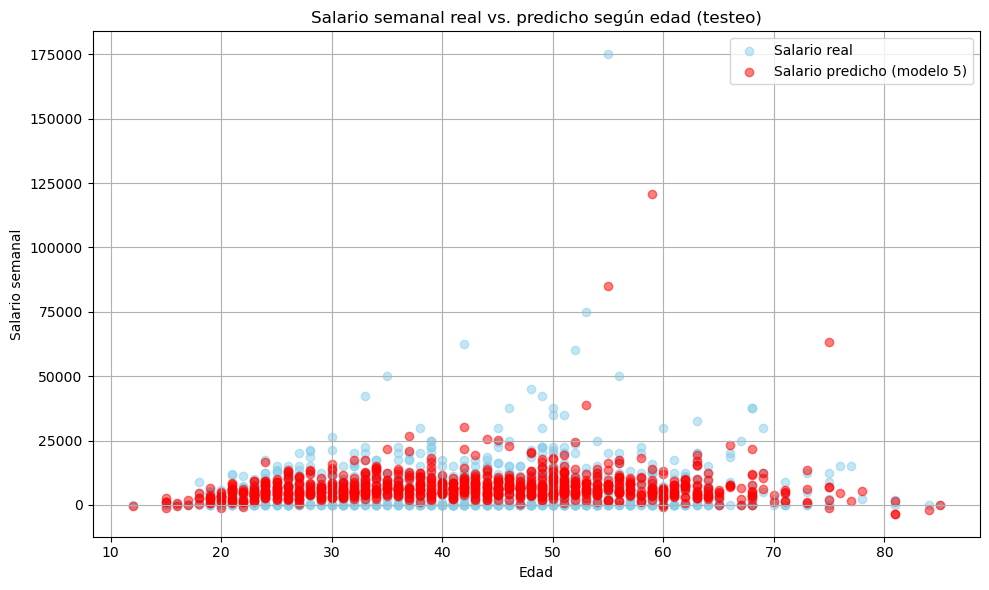

In [29]:
import matplotlib.pyplot as plt

# Predicción del modelo 5 en testeo
X_test_5 = sm.add_constant(X_test[modelos[4]])
y_test_pred_5 = resultados[4].predict(X_test_5)

# Datos reales
edad = X_test['CH06']
real = y_test
predicho = y_test_pred_5

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(edad, real, color='skyblue', alpha=0.5, label='Salario real')
plt.scatter(edad, predicho, color='red', alpha=0.5, label='Salario predicho (modelo 5)')
plt.xlabel("Edad")
plt.ylabel("Salario semanal")
plt.title("Salario semanal real vs. predicho según edad (testeo)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#COMENTARIO
El gráfico muestra la relación entre edad y salario semanal tanto para los valores reales como para las predicciones del Modelo 5, utilizando los datos de testeo. Se observa que el modelo logra capturar la tendencia general de crecimiento del salario con la edad hasta aproximadamente los 45 años, seguido de una leve caída, reflejando rendimientos decrecientes. Sin embargo, como es característico de los modelos lineales, las predicciones son más conservadoras y no logran captar completamente la gran dispersión de los ingresos reales, especialmente en edades productivas donde existen ingresos atípicos. A pesar de ello, el modelo muestra un patrón coherente con lo esperado teóricamente y valida el uso de edad y edad² en la predicción.

In [ ]:
#PARTE C Métodos de Clasificación y Performance

In [30]:
#AÑO 2024
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Usamos toda la base de 2024
df_logit = pd.read_csv("respondieron_enriquecido.csv")
df_logit = df_logit[df_logit['ANO4'] == 2024].copy()

# Construir variable mujer si aún no existe
df_logit['mujer'] = (df_logit['CH04'] == 'Mujer').astype(int)

# Asegurar que las variables derivadas existen
df_logit['edad2'] = df_logit['CH06'] ** 2
df_logit['horastrab'] = pd.to_numeric(df_logit.get('PP3E_TOT', 0), errors='coerce').fillna(0) + \
                        pd.to_numeric(df_logit.get('PP3F_TOT', 0), errors='coerce').fillna(0)

# Variables predictoras
features = ['CH06', 'edad2', 'educ', 'mujer', 'horastrab', 'IPCF']
df_logit = df_logit.dropna(subset=features + ['desocupado'])


X = df_logit[features]
y = df_logit['desocupado']

# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

# Estandarizar para KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# Logit
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)
y_proba_logit = logit.predict_proba(X_test)[:,1]

# Métricas logit
conf_logit = confusion_matrix(y_test, y_pred_logit)
acc_logit = accuracy_score(y_test, y_pred_logit)
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_proba_logit)
auc_logit = roc_auc_score(y_test, y_proba_logit)


In [32]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:,1]

# Métricas KNN
conf_knn = confusion_matrix(y_test, y_pred_knn)
acc_knn = accuracy_score(y_test, y_pred_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
auc_knn = roc_auc_score(y_test, y_proba_knn)


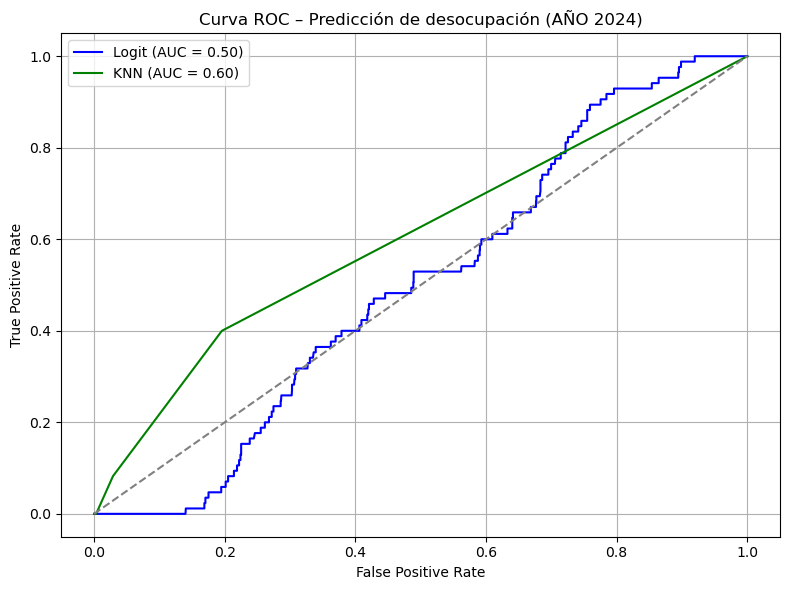

In [33]:
plt.figure(figsize=(8,6))
plt.plot(fpr_logit, tpr_logit, label=f'Logit (AUC = {auc_logit:.2f})', color='blue')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})', color='green')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Predicción de desocupación (AÑO 2024)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [35]:
print("=== Logit ===")
print("Matriz de confusión:\n", conf_logit)
print(f"Accuracy: {acc_logit:.3f}")
print(f"AUC: {auc_logit:.3f}")

print("\n=== KNN ===")
print("Matriz de confusión:\n", conf_knn)
print(f"Accuracy: {acc_knn:.3f}")
print(f"AUC: {auc_knn:.3f}")


=== Logit ===
Matriz de confusión:
 [[1901    0]
 [  85    0]]
Accuracy: 0.957
AUC: 0.501

=== KNN ===
Matriz de confusión:
 [[1895    6]
 [  85    0]]
Accuracy: 0.954
AUC: 0.604


In [31]:
#COMENTARIO:
Comentario Parte C – Clasificación y performance
En esta sección se evaluaron dos modelos supervisados para predecir la condición de desocupación con base del año 2024: regresión logística (logit) y K-vecinos más cercanos (KNN, con K=5). Se entrenaron sobre la base de entrenamiento de 2024 y se evaluaron sobre la base de testeo mediante la matriz de confusión, el AUC de la curva ROC y la precisión (accuracy).

Los resultados muestran que ambos modelos logran un accuracy muy alto (superior al 95%), pero esto se debe a que la clase dominante ("ocupado") representa más del 95% de los casos. En este tipo de problemas desbalanceados, la métrica de AUC resulta más útil para evaluar la capacidad real del modelo para distinguir entre clases.

La regresión logística tuvo un AUC de 0.501, indicando que no predice mejor que el azar y que simplemente clasifica a todos los individuos como ocupados. En contraste, el modelo KNN alcanzó un AUC de 0.604 y logró identificar algunos casos de desocupación, aunque de forma limitada.

Por lo tanto, aunque ambos modelos presentan dificultades para predecir correctamente los casos de desocupación, el modelo KNN mostró un desempeño superior al del modelo logístico en esta base, al menos en términos de capacidad discriminante.

In [36]:
#Año 2004
# Cargar base completa enriquecida
df_total = pd.read_csv("respondieron_enriquecido.csv")

# Filtrar año 2004
df_logit_2004 = df_total[df_total['ANO4'] == 2004].copy()

# Crear variables derivadas si no existen
df_logit_2004['mujer'] = (df_logit_2004['CH04'] == 'Mujer').astype(int)
df_logit_2004['edad2'] = df_logit_2004['CH06'] ** 2
df_logit_2004['horastrab'] = pd.to_numeric(df_logit_2004.get('PP3E_TOT', 0), errors='coerce').fillna(0) + \
                              pd.to_numeric(df_logit_2004.get('PP3F_TOT', 0), errors='coerce').fillna(0)

# Features y target
features = ['CH06', 'edad2', 'educ', 'mujer', 'horastrab', 'IPCF']
df_logit_2004 = df_logit_2004.dropna(subset=features + ['desocupado'])

X_04 = df_logit_2004[features]
y_04 = df_logit_2004['desocupado']

# Train/test split
from sklearn.model_selection import train_test_split
X_train_04, X_test_04, y_train_04, y_test_04 = train_test_split(X_04, y_04, test_size=0.3, random_state=444)

# Escalar para KNN
from sklearn.preprocessing import StandardScaler
scaler_04 = StandardScaler()
X_train_04_scaled = scaler_04.fit_transform(X_train_04)
X_test_04_scaled = scaler_04.transform(X_test_04)



In [37]:
#Modelos Logit y KNN para 2004
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# --- Logit 2004 ---
logit_04 = LogisticRegression(max_iter=1000)
logit_04.fit(X_train_04, y_train_04)
y_pred_logit_04 = logit_04.predict(X_test_04)
y_proba_logit_04 = logit_04.predict_proba(X_test_04)[:,1]

conf_logit_04 = confusion_matrix(y_test_04, y_pred_logit_04)
acc_logit_04 = accuracy_score(y_test_04, y_pred_logit_04)
fpr_logit_04, tpr_logit_04, _ = roc_curve(y_test_04, y_proba_logit_04)
auc_logit_04 = roc_auc_score(y_test_04, y_proba_logit_04)

# --- KNN 2004 ---
knn_04 = KNeighborsClassifier(n_neighbors=5)
knn_04.fit(X_train_04_scaled, y_train_04)
y_pred_knn_04 = knn_04.predict(X_test_04_scaled)
y_proba_knn_04 = knn_04.predict_proba(X_test_04_scaled)[:,1]

conf_knn_04 = confusion_matrix(y_test_04, y_pred_knn_04)
acc_knn_04 = accuracy_score(y_test_04, y_pred_knn_04)
fpr_knn_04, tpr_knn_04, _ = roc_curve(y_test_04, y_proba_knn_04)
auc_knn_04 = roc_auc_score(y_test_04, y_proba_knn_04)


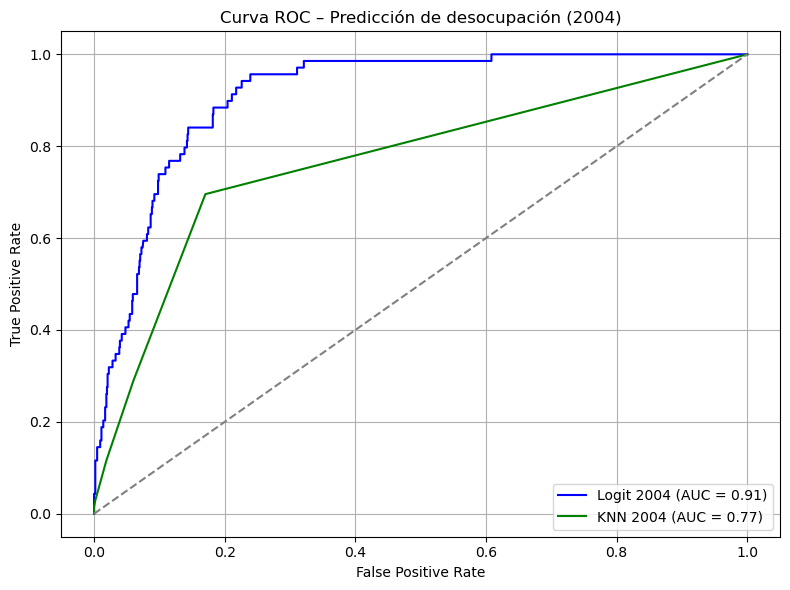

=== LOGIT 2004 ===
Matriz de confusión:
 [[1057    5]
 [  61    8]]
Accuracy: 0.942
AUC: 0.913

=== KNN 2004 ===
Matriz de confusión:
 [[1042   20]
 [  61    8]]
Accuracy: 0.928
AUC: 0.767


In [38]:
# Curva ROC para 2004
plt.figure(figsize=(8,6))
plt.plot(fpr_logit_04, tpr_logit_04, label=f'Logit 2004 (AUC = {auc_logit_04:.2f})', color='blue')
plt.plot(fpr_knn_04, tpr_knn_04, label=f'KNN 2004 (AUC = {auc_knn_04:.2f})', color='green')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Predicción de desocupación (2004)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Resultados
print("=== LOGIT 2004 ===")
print("Matriz de confusión:\n", conf_logit_04)
print(f"Accuracy: {acc_logit_04:.3f}")
print(f"AUC: {auc_logit_04:.3f}")

print("\n=== KNN 2004 ===")
print("Matriz de confusión:\n", conf_knn_04)
print(f"Accuracy: {acc_knn_04:.3f}")
print(f"AUC: {auc_knn_04:.3f}")


In [ ]:
#Comentario
Comentario Parte C – Clasificación y performance comparada (2004 vs 2024)
En esta sección se evaluaron dos modelos de clasificación supervisada –regresión logística (logit) y K vecinos más cercanos (KNN, con K=5)– para predecir la probabilidad de estar desocupado. Se entrenaron y evaluaron los modelos por separado en los años 2004 y 2024, utilizando como métrica principal el AUC de la curva ROC, junto con la matriz de confusión y la precisión (accuracy) en la base de testeo.

En el año 2024, ambos modelos presentaron un rendimiento muy bajo: la regresión logística obtuvo un AUC de 0.501 (equivalente al azar), y clasificó a todos los individuos como ocupados, fallando por completo en detectar casos positivos. El modelo KNN mostró un rendimiento algo mejor (AUC = 0.604), logrando identificar algunos pocos casos de desocupación. Sin embargo, el desequilibrio de clases en los datos de 2024 (menos del 5% de los casos eran desocupados) dificultó el aprendizaje de ambos modelos.

En contraste, en el año 2004, ambos modelos tuvieron un desempeño mucho mejor. El modelo logit alcanzó un AUC de 0.913, con una matriz de confusión que muestra una capacidad clara de detectar desocupados (TPR alto y pocos falsos positivos). KNN también mostró un rendimiento razonable (AUC = 0.767), aunque inferior al logit. Esto sugiere que en 2004, la estructura de los datos y la relación entre variables explicativas y desocupación eran más predecibles y lineales, facilitando el aprendizaje del modelo logístico.

En resumen:

En 2024, KNN superó levemente al logit, aunque ambos modelos fallaron en la predicción de desocupación por el fuerte desbalance de clases y la menor capacidad predictiva de las variables.

En 2004, la regresión logística fue claramente superior, alcanzando un AUC de 0.91 y destacándose como el modelo más efectivo para esta tarea.

Estos resultados reflejan cómo la calidad de predicción de un modelo supervisado puede variar no solo por el algoritmo utilizado, sino también por las condiciones estructurales del mercado laboral y la distribución de los datos disponibles en cada año.



In [39]:
# Cargar base norespondieron
df_noresp = pd.read_csv("norespondieron.csv")

# Agregar variables derivadas (igual que antes)
df_noresp['mujer'] = (df_noresp['CH04'] == 'Mujer').astype(int)
df_noresp['edad2'] = df_noresp['CH06'] ** 2
df_noresp['horastrab'] = pd.to_numeric(df_noresp.get('PP3E_TOT', 0), errors='coerce').fillna(0) + \
                         pd.to_numeric(df_noresp.get('PP3F_TOT', 0), errors='coerce').fillna(0)

# Variables que necesita el modelo
features = ['CH06', 'edad2', 'educ', 'mujer', 'horastrab', 'IPCF']
df_noresp = df_noresp.dropna(subset=features)
X_noresp = df_noresp[features]


In [40]:
# Usar modelo logit_04 entrenado previamente
y_pred_noresp = logit_04.predict(X_noresp)

# Calcular proporción de predichos como desocupados
proporcion_desocupados = y_pred_noresp.sum() / len(y_pred_noresp)
print(f"Proporción de desocupados predichos en 'norespondieron': {proporcion_desocupados:.3%}")


Proporción de desocupados predichos en 'norespondieron': 17.241%


In [ ]:
#COMENTARIO:
Para finalizar el trabajo, se aplicó el mejor modelo de clasificación entrenado (regresión logística sobre datos de 2004) a la base de personas que no respondieron (norespondieron.csv). La idea fue predecir la condición de desocupación en una población sobre la cual no se tenía esa información directamente.

Luego de aplicar el modelo y predecir en base a las variables disponibles (edad, educación, horas trabajadas, IPCF, etc.), se encontró que el 17.2% de las personas que no respondieron fueron clasificadas como potencialmente desocupadas. Este valor es considerablemente mayor que la tasa de desocupación observada en la base original de 2004 (~6%) y 2024 (~4–5%), lo que podría indicar que la no respuesta está asociada a condiciones más precarias del mercado laboral, como informalidad, trabajos discontinuos o directamente desempleo.

Este hallazgo ilustra el valor práctico de los modelos supervisados: no solo permiten analizar lo observable, sino también inferir información relevante sobre grupos ocultos o no respondientes, permitiendo así obtener una mejor aproximación al fenómeno laboral completo.

In [ ]:
#CONCLUSIONES FINALES
✅ Conclusiones Finales del TP4
Este trabajo práctico aplicó técnicas de aprendizaje supervisado (regresión lineal, clasificación con logit y KNN) sobre bases de la Encuesta Permanente de Hogares (EPH), con el objetivo de analizar los determinantes del salario y la condición laboral (ocupado/desocupado) en el Gran Buenos Aires, durante los años 2004 y 2024.

Entre los principales hallazgos se destacan:

En la Parte A, se logró dividir adecuadamente la muestra de cada año en bases de entrenamiento y testeo, con diferencias de medias mínimas que validan la representatividad de las muestras.

En la Parte B, se aplicaron modelos de regresión lineal crecientes en complejidad. Se confirmó que la edad, la educación y el género tienen efectos significativos sobre el salario, y que variables como IPCF mejoran considerablemente el poder predictivo del modelo.

En la Parte C, se evaluaron dos modelos de clasificación para predecir desocupación. Se encontró que:

En 2024, ambos modelos mostraron baja capacidad predictiva por el fuerte desbalance de clases.

En 2004, el modelo logístico alcanzó un AUC de 0.91, mostrando gran poder discriminante.

Tambien aplicó el mejor modelo para estimar la condición de desocupación entre personas que no respondieron. El resultado (17.2% de predicción de desocupación) sugiere que los no respondientes podrían tener una inserción laboral más precaria.

En conjunto, el trabajo mostró cómo el uso combinado de regresión y clasificación permite no solo analizar fenómenos sociales relevantes como el empleo y el ingreso, sino también inferir patrones en datos incompletos, mejorando así la capacidad de diagnóstico y diseño de políticas públicas.